In [1]:
import numpy as np     
import pandas as pd
import matplotlib                          
import matplotlib.pyplot as plt
from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import * 
import pandas as pd
from pykat.parallel import parakat

%config InlineBackend.figure_format='svg'
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [52]:
HG33base = finesse.kat()         
HG33base.verbose = False

HG33base.parse( """
l laser 100 0 n0          
s s0 1 n0 nBSb                        

## Central beam splitter ##
bs1 BS 0.5 3.75e-05 0 45 nBSb nBSy nBSx nBSd 

#higher order mode HG33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0
                                                                                                   
## X arm ##                   
s slX 7 nBSx nX1
m1 ITMX 0.014 3.75e-05 0 nX1 nX2
s sLX 3994.4692 nX2 nX3 
m1 ETMX 5e-06 3.75e-05 0 nX3 dump
cav cavityX ITMX nX2 ETMX nX3

## Y arm ##
s slY 7 nBSy nY1
m1 ITMY 0.014 3.75e-05 90 nY1 nY2
s sLY 3994.4692 nY2 nY3 
m1 ETMY 5e-06 3.75e-05 90 nY3 dump
cav cavityY ITMY nY2 ETMY nY3

# 1ppm again
attr ETMX Rc 2679.93
attr ETMY Rc 2679.93
attr ITMX Rc -2679.93
attr ITMY Rc -2679.93


maxtem 8

""")      

In [53]:
LG22base = finesse.kat()         
LG22base.verbose = False

LG22base.parse( """
l laser 100 0 n0          
s s0 1 n0 nBSb                        

## Central beam splitter ##
bs1 BS 0.5 3.75e-05 0 45 nBSb nBSy nBSx nBSd 

#higher order mode LG22
tem laser 0 0 0 0
tem laser 6 0 0.234375 0
tem laser 5 1 0.15625 -90
tem laser 4 2 0.015625 0
tem laser 3 3 0.1875 -90
tem laser 2 4 0.015625 180
tem laser 1 5 0.15625 -90
tem laser 0 6 0.234375 180
                                                                                                   
## X arm ##                   
s slX 7 nBSx nX1
m1 ITMX 0.014 3.75e-05 0 nX1 nX2
s sLX 3994.4692 nX2 nX3 
m1 ETMX 5e-06 3.75e-05 0 nX3 dump
cav cavityX ITMX nX2 ETMX nX3

## Y arm ##
s slY 7 nBSy nY1
m1 ITMY 0.014 3.75e-05 90 nY1 nY2
s sLY 3994.4692 nY2 nY3 
m1 ETMY 5e-06 3.75e-05 90 nY3 dump
cav cavityY ITMY nY2 ETMY nY3

# 1ppm again
attr ETMX Rc 2789.58
attr ETMY Rc 2789.58
attr ITMX Rc -2789.58
attr ITMY Rc -2789.58


maxtem 8

""")      

In [58]:
pkLG=parakat()
for i in range(30):
    LG22contrast = LG22base.deepcopy()  
    LG22contrast.parse(f"""
            map ETMY randommaps/randommap{i}.txt
            map ETMX randommaps/randommap{i+1}.txt
            map ITMY randommaps/randommap{i+2}.txt
            map ITMX randommaps/randommap{i+3}.txt
            pd darkport nBSd 
            pd brightport nBSb
            """)
    LG22contrast.noxaxis = True
    pkLG.run(LG22contrast)
    
outLG = pkLG.getResults()
contrastLG = []
for i in range(30):
    contrast=outLG[i]['darkport']/outLG[i]['brightport']
    contrastLG.append(contrast)

pd.Series(contrastLG).to_pickle('pkl/LG22contrast.pkl')

Parallel jobs: 100%|##########################################################|

In [60]:
pkHG=parakat()
for i in range(30):
    HG33contrast = HG33base.deepcopy()  
    HG33contrast.parse(f"""
            map ETMY randommaps/randommap{i}.txt
            map ETMX randommaps/randommap{i+1}.txt
            map ITMY randommaps/randommap{i+2}.txt
            map ITMX randommaps/randommap{i+3}.txt
            pd darkport nBSd 
            pd brightport nBSb
            """)
    HG33contrast.noxaxis = True
    pkHG.run(HG33contrast)
    
outHG = pkHG.getResults()
contrastHG = []
for i in range(30):
    contrast=outHG[i]['darkport']/outHG[i]['brightport']
    contrastHG.append(contrast)
    
pd.Series(contrastHG).to_pickle('pkl/HG33contrast.pkl')

Parallel jobs: 100%|##########################################################|

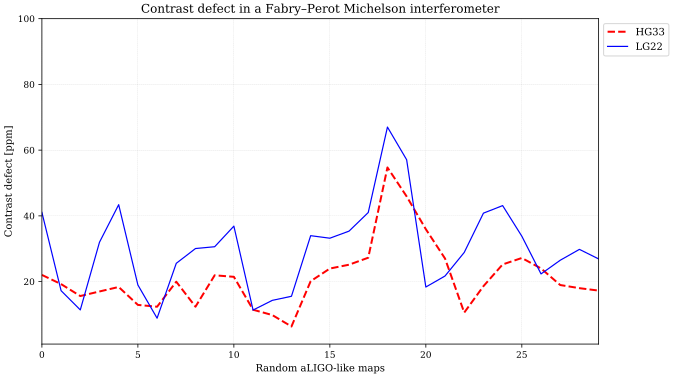

In [2]:
HG33contrast=pd.read_pickle('pkl/HG33contrast.pkl').values
LG22contrast=pd.read_pickle('pkl/LG22contrast.pkl').values

fig,ax =plt.subplots(figsize=(10,6))
ax.plot(HG33contrast*1e6,'r--',label='HG33',linewidth=2)
ax.plot(LG22contrast*1e6,'b',label='LG22')
ax.set_title('Contrast defect in a Fabry–Perot Michelson interferometer')
ax.set_xlabel("Random aLIGO-like maps")
ax.set_ylabel("Contrast defect [ppm]")
ax.set_ylim(1,100)
ax.legend(loc=2,bbox_to_anchor=(1,1))
plt.show()